<a href="https://colab.research.google.com/github/ahmetmungan/DeepLearningProjects/blob/biomedical_project/XceptionVeMobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AHMET MUNGAN**


In [ ]:
#    1. SORU CEVAPLARI  <<<
# 4 sınıftan oluşan çok sınıflı fakat görsellerde tek bir etiket bulunduğundan tek etiketli bir sorundur.
# Dolayısıyla çıktı aktivasyonu softmax olup, hata fonksiyonu categorical_crossentropi olacaktır.
# Her bir sınıfa ait ölçekleme miktarına (0-255 arası ölçekleme) uyan train, validation, test sıralı olarak -> 7365, 920, 924 adet görsel vardır. Tablo aşağıdadır.
# Ayrıca radyoloji görüntüleri kaydededen cihazların tek kanalda görseller ürettiği düşünülse de, rgb modda görseli kaydettiği de öğrenilmiştir.
# Görseller tek kanallı gibi düşünülürse, modelle birleşince graf çizim problemi (graph execution error) yaşanmıştır.
# Bu problem transfer learning yapılan çoğu modelde input_shape'in varsayılan input_shape değerinden farklıdır.
# Varsayılan input_shape'ler (X, X, 3) şeklinde ve 3 kanallıdır.

#    2. SORU CEVAPLARI  <<<
# Xception varsayılan input_shape değeri (299,299,3) şeklindedir.
# Veri üreteçlerinin target_size (hedeflenen boyut) değeri (299,299) olarak ayarlanmıştır.
# Xception modeli inception versiyonlarını birleştirerek, her bir katmanda seperable denilen 1x1, 3x3 ve 5x5'lik blok filtreler ile konvüle edilmektedir.
# Bu filtreler sayesinde öznitelik haritasında (feature-map) korelasyonu arttırarak, özniteliklerin belirginleşmesini ve doğruluğun yükselmesini sağlamaktadır.
# Özniteliklerin belirgin olması da ağın hesaplama karmaşıklığını küçük oranda da olsa düşürmektedir. Fakat hesaplama karmaşıklığı düşüyor gibi gözükse de parametre sayısı düşmez.

#    3. SORU CEVAPLARI  <<<
# Süre beklenebilecek düzeyde olmadığından, tam bağımlı katmanlar (full-connected) haricinde diğer katmanların eğitilebilirlik özelliği dondurulmuştur.
# Ayrıca tam bağımlı katmanda Xception modelinin varsayılan çıktısı imagenet yarışmasındaki gibi 1000 sınıftan oluşmaktadır.
# Veri setinde 4 farklı sınıf olduğu için, tam bağımlı katmanlarda çıktının softmax ile 4 perceptron olması gerekmektedir.
# Model tanımlanırken include_top için boolean değerinin son katman haricinde 1 adet genel ortalama havuzlama (global average pooling) yapılmaktadır.
# Bu havuzlama ve ardından 4 sınıflı çıktı birleştirilerek, ayrıca sürenin kısalması için araya drop out eklenerek modelin outputu oluşturulmuştur.
# Süre nedeniyle epok sayısı mecburiyetten 5 seçilmiştir.
# Bazı konvolüsyon katmanlarının dondurulmayıp eğitilmesi denenmiştir, bu süreçte sonuçların çok büyük değişiklikler göstermediği için dondurulmuştur.
# Modelin son halinden evvel bir çok hata alınmış, jupyter notebook üzerinde modeller sayısız defa denenmiştir.

#    4. SORU CEVAPLARI  <<<
# Jupyter Notebook üzerindeki denemelerde overfitting olmamıştır.





#    2. MODEL  <<<
# 2. seçilen model ise MobileNetV2'dir. Seçilmesindeki asıl amaç parametre sayısının ve modelin karmaşıklığının az olmasıdır.
# MobileNetV2 mimarisi düşük hesaplama gücüne sahip donanımlar için idealdir. Ayrılabilir (separeble) konvolüsyon katmanlarının sayısı azdır. Bu sayede daha küçük bir modeldir.
# MobileNetV2 mimarisinde Xception mimarisine göre ayrılabilir konvolüsyon açısından farkılıdır.
# Derinlemesine (deep-wise) konvolüsyonda girişe göre 2 boyutlu derinlik filtresi uygulanırken, ayrılabilir (seperable) konvolüsyonda filtrenin derinliği ile boyutu ayrılabilir.
# İki modelin birbirine göre en temel farkı budur.
# Jupyter Notebook'ta 50 epok ile denenmiş, validation accuracy ile train accuracy fonksiyon çizgilerinin birbirinden çok ayrı kaldığı fark edilmiştir.
# Dolayısıyla bir overfitting durumu meydana gelmiştir ve erken durdurma (early-stop) ile epok sayısı 20 ile sınırlandırılmıştır.
# Ayrıca epok sayısının düşürülmesi eğitim süresini de kısaltmıştır.

In [ ]:
from keras.models import Sequential,Model,Input
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D,Input,Concatenate,AveragePooling2D,BatchNormalization,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
trainPath="./drive/MyDrive/Colab Notebooks/Data/train"
testPath="./drive/MyDrive/Colab Notebooks/Data/test"
valPath="./drive/MyDrive/Colab Notebooks/Data/val"

trainDataGen=ImageDataGenerator(rescale=1./255)
testDataGen=ImageDataGenerator(rescale=1./255)
valDataGen=ImageDataGenerator(rescale=1./255)

trainGen=trainDataGen.flow_from_directory(
    trainPath,
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    subset='training')

valGen=trainDataGen.flow_from_directory(
    valPath,
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32)

testGen=testDataGen.flow_from_directory(
    testPath,
    target_size=(299,299),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32)

tablo = pd.DataFrame(data=[trainGen.n, valGen.n, testGen.n], index = ["Eğitim", "Doğrulama", "Test"], columns = ["Birim Sayısı"])
tablo

Found 7365 images belonging to 4 classes.
Found 920 images belonging to 4 classes.
Found 924 images belonging to 4 classes.


,Birim Sayısı
Eğitim,7365
Doğrulama,920
Test,924


In [ ]:
from tensorflow.keras.applications import Xception
base_model=Xception(include_top=False, input_shape = (299,299,3)) # Çıktı katmanı 1000 sınıftan oluşmadığı için fine tuning yapılacağından çıktı katmanları dahil edilmemiştir.
for layer in base_model.layers:
    layer.trainable = False # Bütün ağırlıklar imagenet'teki ağırlıklar olarak bırakılmıştır.

x = base_model.output
print(x)
x = GlobalAveragePooling2D()(x) # Model burada hem flat ediyor hem de pooling işlemi uyguluyor. Modelin mimarisinde bulunmaktadır.
x = Dropout(0.5)(x) # Daha hızlı çalışması için drop out uygulanmıştır.
FC_tahmin = Dense(4, activation="softmax")(x) # 4 sınıflı bir veri seti olduğundan çıktı katmanı 4 olarak tanımlanmıştır.
model = Model(inputs = base_model.input, outputs = FC_tahmin)

model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 10, 2048), dtype=tf.float32, name=None), name='block14_sepconv2_act/Relu:0', description="created by layer 'block14_sepconv2_act'")
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 block1_

In [ ]:
history = model.fit(trainGen, validation_data = valGen, epochs = 5, batch_size = 64) # Hızlı sonuç vermesi için 5 epok olarak belirlenmiştir. Geçen süre 02:12:39

Epoch 1/5
231/231 [==============================] - 7022s 30s/step - loss: 0.8087 - accuracy: 0.6975 - val_loss: 0.5827 - val_accuracy: 0.7924
Epoch 2/5
231/231 [==============================] - 232s 1s/step - loss: 0.5945 - accuracy: 0.7712 - val_loss: 0.5157 - val_accuracy: 0.8098
Epoch 3/5
231/231 [==============================] - 224s 970ms/step - loss: 0.5507 - accuracy: 0.7848 - val_loss: 0.4936 - val_accuracy: 0.8185
Epoch 4/5
231/231 [==============================] - 221s 955ms/step - loss: 0.5266 - accuracy: 0.7939 - val_loss: 0.4740 - val_accuracy: 0.8174
Epoch 5/5
231/231 [==============================] - 218s 942ms/step - loss: 0.5061 - accuracy: 0.8004 - val_loss: 0.4626 - val_accuracy: 0.8217


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


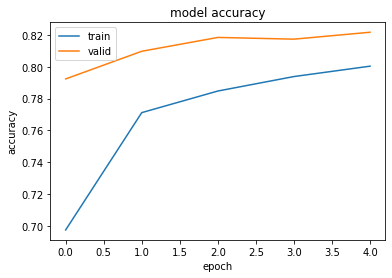

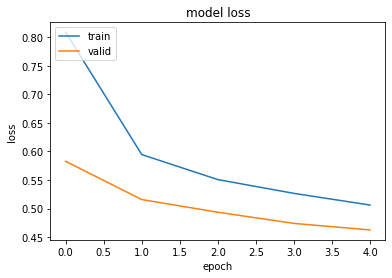

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show() # epok sayısı az olduğundan grafikte net bir şekilde overfitting veya underfitting görülmemektedir.

28/28 [==============================] - 762s 28s/step
['COVID-19' 'Normal' 'Pneumonia-Bacterial' 'Pneumonia-Viral']


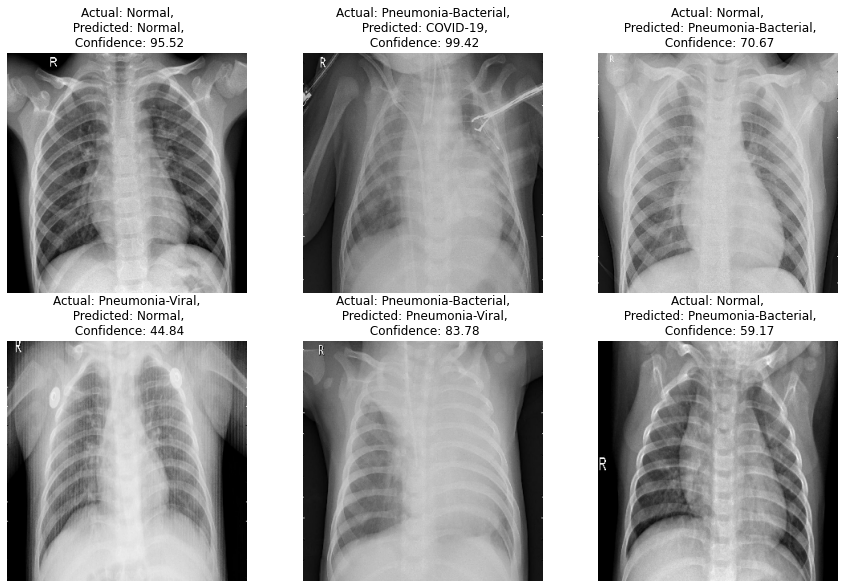

In [ ]:

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

target_labels = next(os.walk(trainPath))[1]
target_labels.sort()
num_classes = len(target_labels)

pred = model.predict(testGen, steps=28, verbose=1)

batch = next(testGen)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

target_labels = np.asarray(target_labels)
print(target_labels)

plt.figure(figsize=(15,15))
for n, i in enumerate(np.arange(6)):
    actual = target_labels[np.argmax(batch_labels[i])]
    predicted = target_labels[np.argmax(pred[i])]
    confidence = round(100*(np.max(pred[i])),2)

    ax = plt.subplot(3,3,n+1)
    plt.imshow(batch_images[i])
    plt.title(f"Actual: {actual},\n Predicted: {predicted},\n Confidence: {confidence}")
    plt.axis('off')

y_true:  [1, 2, 1, 3, 2, 1, 1, 2, 1, 2, 1, 2, 3, 2, 1, 2, 1, 2, 2, 3, 3, 2, 1, 0, 1, 1, 2, 1, 2, 1, 1, 0]
y_pred:  [0, 2, 0, 1, 2, 0, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 2, 1, 1, 2, 0, 1, 0, 0, 2, 0, 2, 0, 0, 1]


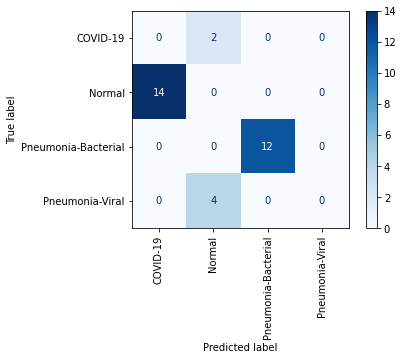

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
y_true_lista = []
y_pred_lista = []
for i, img in enumerate(batch_labels):
    y_true = np.argmax(batch_labels[i]).reshape(-1)
    for i in y_true:
        y_true_lista.append(i)

    y_pred = np.argmax(pred[i]).reshape(-1)
    for i in y_pred:
        y_pred_lista.append(i)

print("y_true: ", y_true_lista)
print("y_pred: ", y_pred_lista)
matrix = confusion_matrix(y_true, y_pred)

labels = target_labels

cm = confusion_matrix(y_true_lista, y_pred_lista)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues, xticks_rotation = 'vertical')

plt.show()

Seçilen 2. Model: MobileNetV2

In [ ]:
trainDataGen2 = ImageDataGenerator(rescale=1./255)
testDataGen2 = ImageDataGenerator(rescale=1./255)
valDataGen2 = ImageDataGenerator(rescale=1./255)

trainPath="./drive/MyDrive/Colab Notebooks/Data/train"
testPath="./drive/MyDrive/Colab Notebooks/Data/test"
valPath="./drive/MyDrive/Colab Notebooks/Data/val"

trainGen2 = trainDataGen2.flow_from_directory(
    trainPath,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    subset='training')

valGen2 = trainDataGen2.flow_from_directory(
    valPath,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32)

testGen2 = testDataGen2.flow_from_directory(
    testPath,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32)
tablo = pd.DataFrame(data=[trainGen2.n, valGen2.n, testGen2.n], index = ["Eğitim", "Doğrulama", "Test"], columns = ["Birim Sayısı"])
tablo

Found 7365 images belonging to 4 classes.
Found 920 images belonging to 4 classes.
Found 924 images belonging to 4 classes.


,Birim Sayısı
Eğitim,7365
Doğrulama,920
Test,924


In [ ]:
from tensorflow.keras.applications import MobileNetV2
base_model2 = MobileNetV2(include_top = False, input_shape = (224,224,3))
for layer in base_model2.layers:
    layer.trainable = False # Bütün ağırlıklar imagenet'teki ağırlıklar olarak bırakılmıştır.

x = base_model2.output
print(x)
x = GlobalAveragePooling2D()(x) # Model burada hem flat ediyor hem de pooling işlemi uyguluyor. Modelin mimarisinde bulunmaktadır.
x = Dropout(0.5)(x) # Daha hızlı çalışması için drop out uygulanmıştır.
FC_tahmin2 = Dense(4, activation="softmax")(x) # 4 sınıflı bir veri seti olduğundan çıktı katmanı 4 olarak tanımlanmıştır.
model2 = Model(inputs = base_model2.input, outputs = FC_tahmin2)

model2.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
model2.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1280), dtype=tf.float32, name=None), name='out_relu/Relu6:0', description="created by layer 'out_relu'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (N

In [ ]:
history2 = model2.fit(trainGen2, validation_data = valGen2, epochs = 20, batch_size = 128) # Parametre sayısı Xception'a göre az olduğu için 20 epok olarak belirlenmiştir. Geçen süre 01:53:07

Epoch 1/20
231/231 [==============================] - 3183s 14s/step - loss: 0.8261 - accuracy: 0.6759 - val_loss: 0.4539 - val_accuracy: 0.8196
Epoch 2/20
231/231 [==============================] - 198s 859ms/step - loss: 0.6005 - accuracy: 0.7585 - val_loss: 0.4471 - val_accuracy: 0.8130
Epoch 3/20
231/231 [==============================] - 189s 817ms/step - loss: 0.5570 - accuracy: 0.7728 - val_loss: 0.4210 - val_accuracy: 0.8326
Epoch 4/20
231/231 [==============================] - 191s 828ms/step - loss: 0.5409 - accuracy: 0.7834 - val_loss: 0.3950 - val_accuracy: 0.8533
Epoch 5/20
231/231 [==============================] - 188s 812ms/step - loss: 0.5226 - accuracy: 0.7868 - val_loss: 0.3995 - val_accuracy: 0.8446
Epoch 6/20
231/231 [==============================] - 189s 819ms/step - loss: 0.5158 - accuracy: 0.7893 - val_loss: 0.4188 - val_accuracy: 0.8326
Epoch 7/20
231/231 [==============================] - 189s 819ms/step - loss: 0.5193 - accuracy: 0.7921 - val_loss: 0.3913 - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


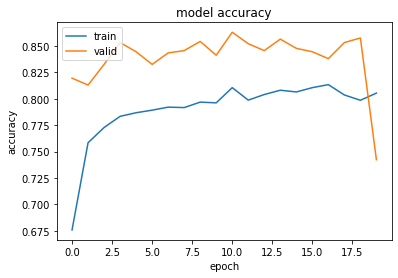

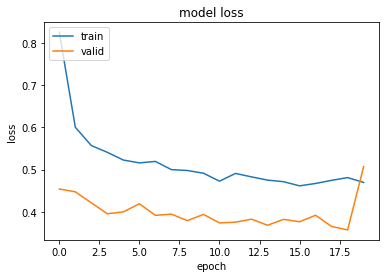

In [ ]:
import matplotlib.pyplot as plt

print(history2.history.keys())

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()